In [1]:
# import required packages
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
import os
import cv2

In [2]:
# read original images. Note that the images should be in a folder called "Inputs" in the current working directory
cwd = os.getcwd() + '\\Inputs\\'

frames = []
for image in os.listdir(cwd):
    path = cwd + image 
    img = cv2.imread(path)
    frames.append(img)

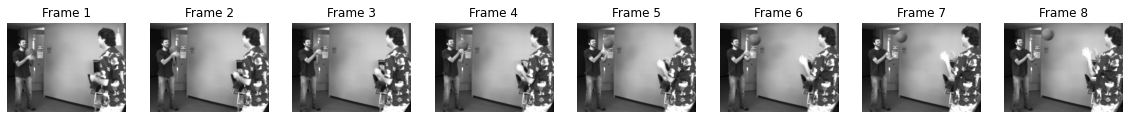

In [3]:
# plot all consecutive original frames
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 8

for i in range(len(frames)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(frames[i])
    plt.axis('off')
    plt.title('Frame ' + str(i+1)) 

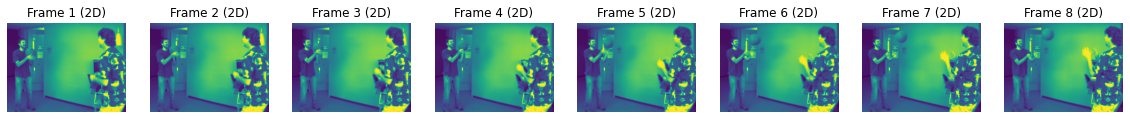

In [4]:
# convert 3D images to 2D images
frames_2d = [img[:,:,0] for img in frames]

# apply Gaussian filter of size 3x3 to eliminate noise
frames_noiseless = []
for i in range(len(frames_2d)):
    img = cv2.GaussianBlur(frames_2d[i], (3, 3), 0)
    frames_noiseless.append(img)

# plot 2D images
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 8
for i in range(len(frames_noiseless)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(frames_noiseless[i])
    plt.axis('off')
    plt.title('Frame ' + str(i+1) + " (2D)") 

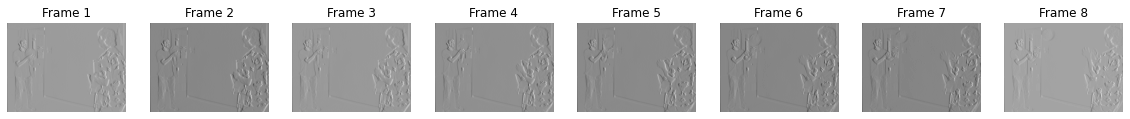

In [5]:
# calculate first derivative in X direction using a 2D filter
filter_x = np.transpose(np.array([[-1., -1.], [1., 1.]]) * 0.25) 
all_fx = []
for img in frames_noiseless:
    fx = signal.convolve2d(img, filter_x, mode='same')
    all_fx.append(fx)

# plot the first derivative of each frame along X
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 8
for i in range(len(all_fx)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(all_fx[i], cmap='gray')
    plt.axis('off')
    plt.title('Frame ' + str(i+1)) 

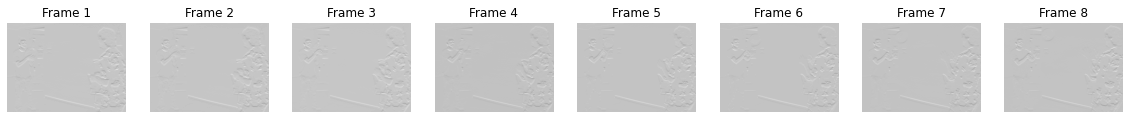

In [6]:
# calculate first derivative in Y direction using a 2D filter
filter_y = np.array([[-1., -1.], [1., 1.]]) * 0.25
all_fy = []
for img in frames_noiseless:
    fy = signal.convolve2d(img, filter_y, mode='same')
    all_fy.append(fy)

# plot the first derivative of each frame along Y
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 8
for i in range(len(all_fy)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(all_fy[i], cmap='gray')
    plt.axis('off')
    plt.title('Frame ' + str(i+1)) 

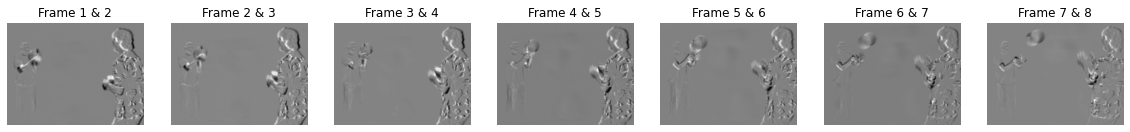

In [7]:
# calculate first derivative in t direction using a 2D filter
filter_current = np.array([[-1., -1.], [-1., -1.]]) * 0.25
filter_next = np.array([[1., 1.], [1., 1.]]) * 0.25
all_ft = []
for i in range(len(frames_noiseless)-1):
    ft = signal.convolve2d(frames_noiseless[i], filter_current, mode='same') + \
         signal.convolve2d(frames_noiseless[i+1], filter_next, mode='same')
    all_ft.append(ft)

# plot the first derivative of each frame along t
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 7
for i in range(len(all_ft)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(all_ft[i], cmap='gray')
    plt.axis('off')
    plt.title('Frame ' + str(i+1) + ' & ' + str(i+2))

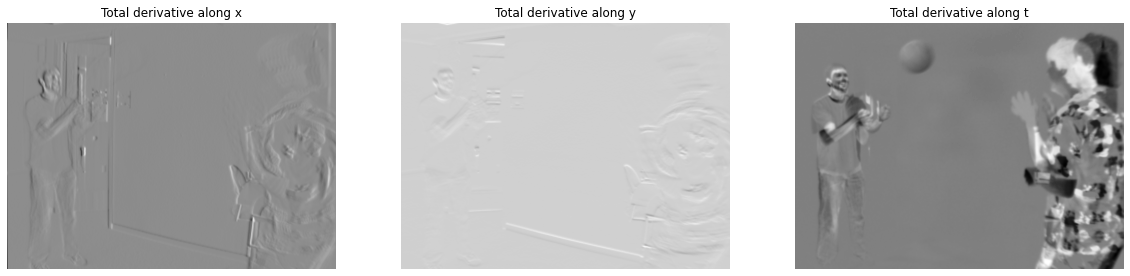

In [8]:
# plot the first derivative of all frames together along X, Y, t
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 3
fx_sum = sum(all_fx)
fig.add_subplot(rows, cols, 1)
plt.imshow(fx_sum, cmap='gray')
plt.axis('off')
plt.title('Total derivative along x')

fy_sum = sum(all_fy)
fig.add_subplot(rows, cols, 2)
plt.imshow(fy_sum, cmap='gray')
plt.axis('off')
plt.title('Total derivative along y')

ft_sum = sum(all_ft)
fig.add_subplot(rows, cols, 3)
plt.axis('off')
plt.title('Total derivative along t')
plt.imshow(ft_sum, cmap='gray')
plt.show()

In [9]:
# calculate the u and v arrays for a 3 by 3 window centered on each pixel using least square fit
h, w = frames_noiseless[0].shape
t = 0.3
u = np.zeros(frames_noiseless[0].shape)
v = np.zeros(frames_noiseless[0].shape)

# within a window of 3 times 3
for i in range(1, h-1):
    for j in range(1, w-1):
        Ix = fx_sum[i-1: i+2, j-1: j+2].flatten()
        Iy = fy_sum[i-1: i+2, j-1: j+2].flatten()
        It = ft_sum[i-1: i+2, j-1: j+2].flatten()
        b = np.reshape(It, (It.shape[0], 1)) 
        A = np.vstack((Ix, Iy)).T 
        
        # if the smallest eigenvalue of A'A is larger than the threshold t, it is moving:
        if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= t:
            nu = np.matmul(np.linalg.pinv(A), b)
            u[i,j] = nu[0]
            v[i,j] = nu[1]

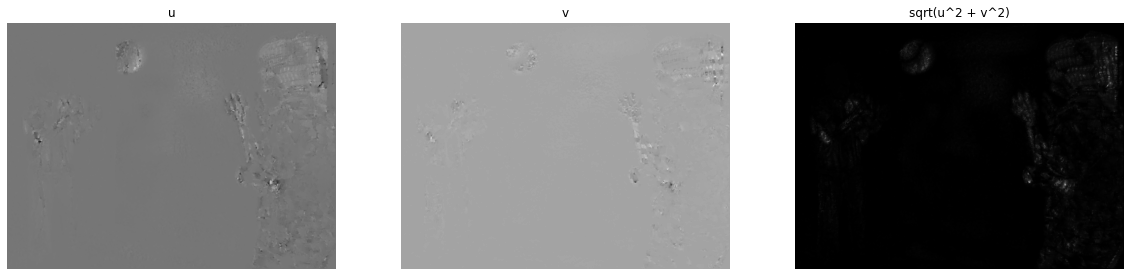

In [10]:
# plot u and v
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 3
fig.add_subplot(rows, cols, 1)
plt.axis('off')
plt.title('u')
plt.imshow(u, cmap='gray')

fig.add_subplot(rows, cols, 2)
plt.axis('off')
plt.title('v')
plt.imshow(v, cmap='gray')

fig.add_subplot(rows, cols, 3)
plt.axis('off')
plt.title("sqrt(u^2 + v^2)")
plt.imshow(np.sqrt(v**2 + u**2), cmap='gray')
plt.show()

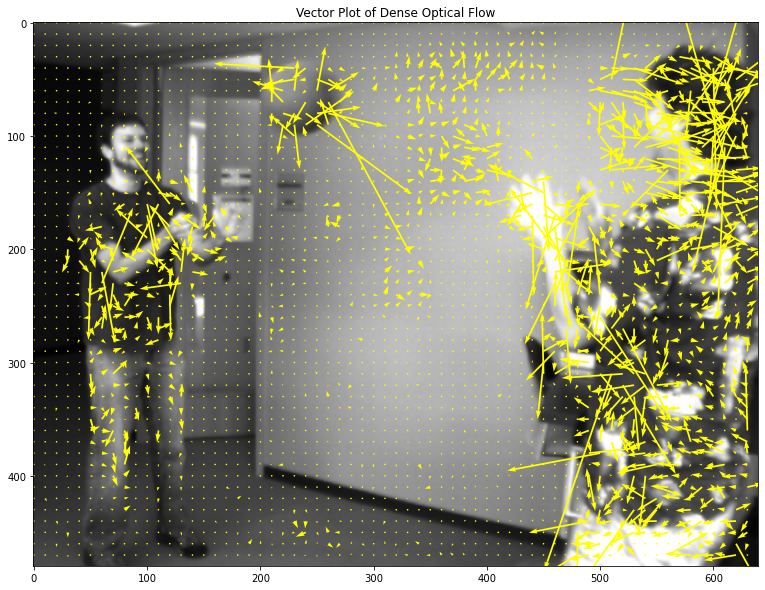

In [11]:
n, m = u.shape

# downsize u and v
u_deci = u[np.ix_(range(0, h, 10), range(0, w, 10))]
v_deci = v[np.ix_(range(0, h, 10), range(0, w, 10))]

# get coordinate for u and v in the original frame
[X,Y] = np.meshgrid(np.arange(w, dtype = 'float64'), np.arange(h, dtype = 'float64'))
X_deci = X[np.ix_(range(0, h, 10), range(0, w, 10))]
Y_deci = Y[np.ix_(range(0, h, 10), range(0, w, 10))]

# plot optical flow field
plt.figure(figsize=(15, 10))
plt.title('Vector Plot of Dense Optical Flow')
plt.imshow(frames_noiseless[7], cmap = 'gray')
plt.quiver(X_deci, Y_deci, u_deci, v_deci, color='yellow')
plt.show()